### Implementation of $\mathbb P_1$ FEM in 1D

We want to solve 
$$
   -u_{xx} = f(x) \quad\text{ on }\quad (0,1), \qquad u(0)=u(1)=0
$$
with $f=1$ in this simple example.

For a subdivision $\mathcal T_h=\{K_i\}_{i=1}^M$ of $\Omega=(0,1)$, define

$$
X_h^1 = \{v\in C^{0}[0,1]\;|\; v|_{K} \in \mathbb{P}_1 \ \forall K\in\mathcal T_h\}\qquad \text{and}\qquad V_h = \{v\in X_h^1: v(0)=0=v(1)\}.
$$

The Galerkin $\mathbb P_1$ FEM is then given by: 

$\qquad$Find $u_h\in V_h$ such that$\qquad a(u_h,v) := \int_0^1 u_h' v'\, dx = \int_0^1 fv\, dx := F(v) \qquad \forall v\in V_h.$

Using the hat-function basis, $X_h^1=\text{span}\{\phi_0,\dots,\phi_M\}$, $u_h(x)=\sum_{i=0}^M U_i \phi_i(x)$, and the FEM becomes a linear system:

$$A \vec U = \vec F$$

where
$$A_{ij}=a(\phi_j,\phi_i),\qquad \vec U = [U_0 , \dots, U_M],\qquad \vec F = [ F(\phi_0), \dots, F(\phi_M) ]$$

#### Implementation

Initialise python libraries, set plotting parameters

In [258]:
%matplotlib inline
import scipy.integrate as integrate
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)

Set ut the subdivision ('triangulation') of space: Choose nodes $x_i$ and elements $K_k=(x_{k-1},x_{k})$. 

In [334]:
Xk = np.array([0, 0.1, 0.3, 0.6, 0.8, 0.9, 0.95, 0.97, 1])  # Nodes, elements K(i) = (x(i-1), x(i))
#Xk = np.linspace(0,1,31)
Mi = len(Xk)                     # Number of nodes
T = np.ndarray.transpose(np.array([Xk[:-1],Xk[1:]])) # Set of elements/triangulation
H = Xk[1:]-Xk[:-1]               # Element sizes
Mk = Mi-1                        # Number of elements

In [260]:
print("\nNodes: ",Xk,"\n\nNumber of nodes: Mi = ", Mi)
print("\nCollection of elements ('triangulation'):\n\n T = \n\n",T,"\n\nNumber of elements: Mk = ", Mk,"\n\nElement sizes: H = ",H)


Nodes:  [0.   0.1  0.3  0.6  0.8  0.9  0.95 0.97 1.  ] 

Number of nodes: Mi =  9

Collection of elements ('triangulation'):

 T = 

 [[0.   0.1 ]
 [0.1  0.3 ]
 [0.3  0.6 ]
 [0.6  0.8 ]
 [0.8  0.9 ]
 [0.9  0.95]
 [0.95 0.97]
 [0.97 1.  ]] 

Number of elements: Mk =  8 

Element sizes: H =  [0.1  0.2  0.3  0.2  0.1  0.05 0.02 0.03]


Set up the elemental stiffness matrix and elemental load vector).

In [261]:
Ak = np.array([[1,-1],[-1,1]])
fk = np.array([1/2,1/2])   # f=1

Find the local to global mapping (here the elements are numbered from 0, and not from 1)

In [262]:
def loc2glob(k,alpha):
    return k+alpha          # Numbering k from 0

def hat_func(i,x):
    if x > x[i-1] and x <= x[i]:
        return (x-x[i-1])/(x[i]-x[i-1])
    elif x > x[i] and x < x[i+1]:
        return (x[i+1]-1)/(x[i+1]-x[i])
    else:
         return 0
        
        
def hat_func_derivative(i,x):
    if x > x[i-1] and x <= x[i]:
        return 1/(x[i]-x[i-1])
    elif x > x[i] and x < x[i+1]:
        return -1/(x[i+1]-x[i])
    else:
         return 0
        


The assembly process:

In [376]:
A = np.zeros((Mi,Mi))
#f = np.zeros((Mi))
b=2
alpha =3
c=2

def stiffness_matrix(i, H, alpha, b, c):
    A_ij=np.zeros(4)
    A_ij[0] = alpha/H[i]-0*b/2+c*H[i]/3
    A_ij[3] = alpha/H[i]-0*b/2+c*H[i]/3
    A_ij[2], A_ij[1] = -alpha/H[i]-b/2-c*H[i]/6, -alpha/H[i]+b/2-c*H[i]/6
    A_ij=A_ij.reshape(2,2)
    return A_ij



for k in range(Mk):
    
    A[k:k+2,k:k+2] += stiffness_matrix(k,H, alpha, b, c)
    
    
def F_phi_1(f,i,x, H):
    
    dx=np.linspace(x[i-1],x[i],50)
    
    F=f(dx)*((dx-x[i-1])/H[i-1])
    
    return F, dx
    
def F_phi_2(f,i,x, H):
    
    dx=np.linspace(x[i],x[i+1],50)
    
    F=f(dx)*((x[i+1]-dx)/H[i])
    
    return F ,dx


def make_F(f,x, Mi,H):
    F_arr=np.zeros(Mi)
    for i in range(Mi-1):
        
        F1, dx1= F_phi_1(f,i,x, H)
        F2, dx2 = F_phi_2(f,i,x, H)
        
        F_arr[i] = integrate.trapezoid(F1,dx1) + integrate.trapezoid(F2,dx2)
        
    return F_arr

def solver(f, x, alpha=3, b=2, c=2):
    
    Mi = len(x)
    Hi=x[1:]-x[:-1]
    
    A = np.zeros((Mi,Mi))
    
    for k in range(Mi-1):
        A[k:k+2,k:k+2] += stiffness_matrix(k, Hi, alpha, b, c)
    
    F=make_F(f,x, Mi, Hi)[1:-1]
    
    A=A[1:-1,1:-1]

    U = np.linalg.solve(A,F)
    U = np.pad(U, pad_width=1)
    
    
    return U, x

Print the resulting matrix $A$ and vector $f$.

In [264]:
print("A=\n", np.around(A,decimals=1, out=None),"\n\n","f=", np.around(f,decimals=1, out=None))

A=
 [[  30.1  -29.     0.     0.     0.     0.     0.     0.     0. ]
 [ -31.    45.2  -14.1    0.     0.     0.     0.     0.     0. ]
 [   0.   -16.1   25.3   -9.1    0.     0.     0.     0.     0. ]
 [   0.     0.   -11.1   25.3  -14.1    0.     0.     0.     0. ]
 [   0.     0.     0.   -16.1   45.2  -29.     0.     0.     0. ]
 [   0.     0.     0.     0.   -31.    90.1  -59.     0.     0. ]
 [   0.     0.     0.     0.     0.   -61.   210.  -149.     0. ]
 [   0.     0.     0.     0.     0.     0.  -151.   250.   -99. ]
 [   0.     0.     0.     0.     0.     0.     0.  -101.   100. ]] 

 f= [  0.   32.8  -1.4 -30.5  28.9  16.6   4.4   1.2   0. ]


Impose the boundary conditions by changing the first and the last equation. 

In [373]:
# Impose boundary condition
# Dirichlet boundary conditions
def f1_exact(x):
    return np.sin(3*np.pi*x)
def test_f1(x):
    return 9*np.pi**2*alpha*np.sin(3*np.pi*x)+3*b*np.pi*np.cos(3*np.pi*x)+c*np.sin(3*np.pi*x)

#f=make_F(test_f1,Xk, Mi)
A[0,:] = 0;
A[0,0] = 1
f[0] = 0
A[-1,:] = 0
A[-1,-1] = 1
f[-1] = 0
print(f)

[  0.          32.76696621  -1.39879549 -30.51562812  28.92160607
  16.55212693   4.43370032   1.20728613   0.        ]


And solve the corresponding linear system

In [358]:
#U = np.linalg.solve(A,f)
Xk=np.linspace(0,1,10)
U, Xk= solver(test_f1,Xk)

Plot the solution. 

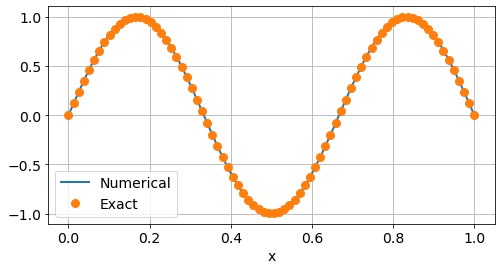

In [374]:
plt.plot(Xk,U,Xk,np.sin(3*np.pi*Xk),'o')
plt.legend(['Numerical','Exact'])
plt.xlabel('x');

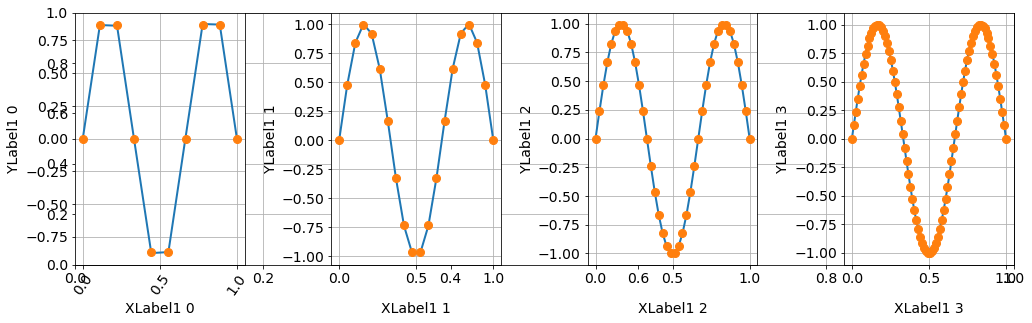

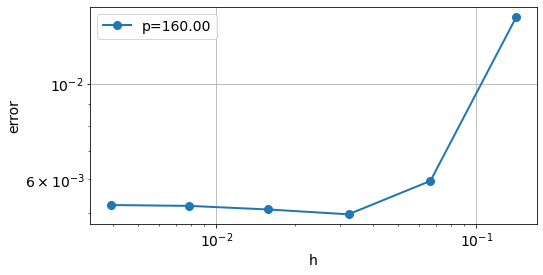

In [386]:
fig = plt.figure(tight_layout=True, figsize=(15,5))
gs = gridspec.GridSpec(1, 4)

ax = fig.add_subplot(gs[0, :])

p=10
for i in range(4):
    
    x=np.linspace(0,1, p)
    U, Xk = solver(test_f1,x)
    ax = fig.add_subplot(gs[0, i])
    ax.plot(Xk,U,Xk,np.sin(3*np.pi*Xk),'o')
    ax.set_ylabel('YLabel1 %d' % i)
    ax.set_xlabel('XLabel1 %d' % i)
    if i == 0:
        ax.tick_params(axis='x', rotation=55)
    p=p*2
fig.align_labels()  # same as fig.align_xlabels(); fig.align_ylabels()

plt.show()


def convergence(u_exact,f, solver): 
    P = 6
    Hconv = np.zeros(P)
    Econv = np.zeros(P)
    M = 8
    for p in range(P):
        x=np.linspace(0,1,M)
        U,x = solver(f, x)
        
        Eh = np.max(np.abs(u_exact(x)[1:-1]-U[1:-1]))  #Taking maximal error on the grid
        
        Hconv[p] = (x[1]-x[0])  #storing stepsize in an array
        Econv[p] = Eh           #storing error corresponding to the stepsize
        M = 2*M
    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]   #making taking the order of convergence by log-log since 
    return Hconv, Econv, order    #the stepsize increases exponentially


H, E, order = convergence(f1_exact,test_f1, solver)
plt.loglog(H,E,'o-', label='p={:.2f}'.format(p))
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.legend();